### Setup

In [1]:
import glob
import io
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import style
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
style.use('ggplot')

/usr/local/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load Dataset and Randomization

In [2]:
mnist_dataframe = pd.read_csv(
    io.open("mnist_train_small.csv", "r"),
    sep=",",
    header=None)
mnist_dataframe = mnist_dataframe.head(10000) # first 10000 rows
mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
8735,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1664,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7875,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1931,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1538,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
display.display(mnist_dataframe.loc[3:10, 50:100])
display.display(mnist_dataframe[0])
display.display(mnist_dataframe.loc[:, 1:784])

,50,51,52,53,54,55,56,57,58,59,...,91,92,93,94,95,96,97,98,99,100
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,76,136,211,255,254
5242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7649,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


8735    3
1664    7
7875    1
1931    4
1538    9
       ..
4431    5
981     5
9718    8
2723    2
7380    3
Name: 0, Length: 10000, dtype: int64

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
8735,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1931,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4431,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9718,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2723,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Parse out Labels and Features

In [4]:
# Column0 represent labels
# Column1 through Column784 represent features --> gray scale pixels
def parse_labels_and_features(dataset):
    labels = dataset[0]
    
    # DataFrame.loc index ranges are inclusive at both ends
    features = dataset.loc[:, 1:784]
    # Scale the data to [0, 1] by dividing out the max value, 255.
    features = features / 255
    return labels, features

### Training set and Validation set

In [5]:
training_targets, training_examples = parse_labels_and_features(mnist_dataframe[:7500])
print("Training Targets Summary: ")
display.display(training_targets.describe())
print("Training Examples Summary: ")
display.display(training_examples.describe())

validation_targets, validation_examples = parse_labels_and_features(mnist_dataframe[7500:10000])
print("Validation Targets Summary: ")
display.display(validation_targets.describe())
print("Validation Examples Summary: ")
display.display(validation_examples.describe())

Training Targets Summary: 


count   7500.0
mean       4.5
std        2.9
min        0.0
25%        2.0
50%        4.0
75%        7.0
max        9.0
Name: 0, dtype: float64

Training Examples Summary: 


,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.3,0.2,1.0,0.2,0.0,0.0,0.0,0.0


Validation Targets Summary: 


count   2500.0
mean       4.6
std        2.9
min        0.0
25%        2.0
50%        5.0
75%        7.0
max        9.0
Name: 0, dtype: float64

Validation Examples Summary: 


,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,...,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Random Example and its corresponding Label

1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
       ..
780   0.0
781   0.0
782   0.0
783   0.0
784   0.0
Name: 3517, Length: 784, dtype: float64

1

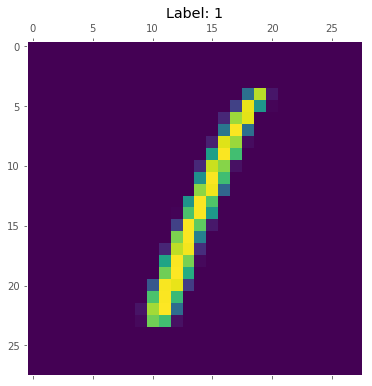

In [6]:
rand_example = np.random.choice(training_examples.index)
display.display(training_examples.loc[rand_example])
display.display(training_targets.loc[rand_example])
plt.figure(figsize=(8, 6))
plt.matshow(training_examples.loc[rand_example].values.reshape(28, 28), fignum=1)
plt.title("Label: %i" % training_targets.loc[rand_example])
plt.grid(False)

In [7]:
mnist_dataframe.loc[rand_example] # prints the whole row including label and features

0      1
1      0
2      0
3      0
4      0
      ..
780    0
781    0
782    0
783    0
784    0
Name: 3517, Length: 785, dtype: int64

## Build a Linear Model for MNIST

### Construct Feature Columns

In [8]:
def construct_feature_columns():
    return set([tf.feature_column.numeric_column('pixels', shape=784)])

### Input Functions

#### Training Input Function

In [9]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
    """A custom input_fn for sending MNIST data to the estimator for training.
    
    Args:
      features: The training features.
      labels: The training labels.
      batch_size: Batch size to use during training.

    Returns:
      A function that returns batches of training features and labels during training.
    """
    def _input_fn(num_epochs=None, shuffle=True):
        # Input pipelines are reset with each call to .train(). To ensure model
        # gets a good sampling of data, even when number of steps is small, we 
        # shuffle all the data before creating the Dataset object
        idx = np.random.permutation(features.index)
        raw_features = {"pixels": features.reindex(idx)}
        raw_targets = np.array(labels[idx])
        
        ds = Dataset.from_tensor_slices((raw_features, raw_targets))
        ds = ds.batch(batch_size).repeat(num_epochs)
        if shuffle:
            ds = ds.shuffle(buffer_size=10000)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

#### Predict Input Function

In [10]:
def create_predict_input_fn(features, labels, batch_size):
    """A custom input_fn for sending mnist data to the estimator for predictions.

    Args:
      features: The features to base predictions on.
      labels: The labels of the prediction examples.

    Returns:
      A function that returns features and labels for predictions.
    """
    def _input_fn():
        raw_features = {"pixels": features.values}
        raw_targets = np.array(labels)
        
        ds = Dataset.from_tensor_slices((raw_features, raw_targets))
        ds = ds.batch(batch_size)
        
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

### Train Linear Classification Model

In [11]:
def train_linear_classification_model(learning_rate,
                                      steps,
                                      batch_size,
                                      training_examples,
                                      training_targets,
                                      validation_examples,
                                      validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    # Input Functions
    training_input_fn = create_training_input_fn(training_examples,
                                                 training_targets,
                                                 batch_size)
    predict_training_input_fn = create_predict_input_fn(training_examples,
                                                        training_targets,
                                                        batch_size)
    predict_validation_input_fn = create_predict_input_fn(validation_examples,
                                                           validation_targets,
                                                           batch_size)
    
    # Create LinearClassifier object and configure it
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.LinearClassifier(
        feature_columns = construct_feature_columns(),
        n_classes = 10,
        optimizer = my_optimizer,
        config = tf.estimator.RunConfig(keep_checkpoint_max=1)
    )
    
    # Train the model in a loop
    print("Training model...")
    print("  LogLoss error (on training data & validation_data): ")
    training_errors = []
    validation_errors = []
    for period in range(0, periods):
        classifier.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
        
        # Compute probabilities
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id, 10)
        
        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id, 10)
        
        # Compute training and validation error
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        print("    Period %02d : %0.2f\t%0.2f" % (period+1,
                                                  training_log_loss,
                                                  validation_log_loss))
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")
    
    # Remove event files to save disk space
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
    
    # Calculate final predictions (not probabilities as above)
    final_predicitions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predicitions = np.array([item['class_ids'][0] for item in final_predicitions])
    
    accuracy = metrics.accuracy_score(validation_targets, final_predicitions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)
    
    # Graph of loss metrics over periods
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_errors, label="training", color="magenta")
    plt.plot(validation_errors, label="validation",color="g")
    plt.legend()
    plt.show()
    
    # Graph the confusion matrix
    cm = metrics.confusion_matrix(validation_targets, final_predicitions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("predicted label")
    plt.show()
    return classifier

Training model...
  LogLoss error (on training data & validation_data): 
    Period 01 : 13.82	14.22
    Period 02 : 10.44	10.72
    Period 03 : 8.84	9.10
    Period 04 : 8.32	8.61
    Period 05 : 7.16	7.20
    Period 06 : 6.92	7.36
    Period 07 : 6.42	7.07
    Period 08 : 6.22	6.49
    Period 09 : 6.22	6.49
    Period 10 : 5.96	6.09
Model training finished.
Final accuracy (on validation data): 0.82


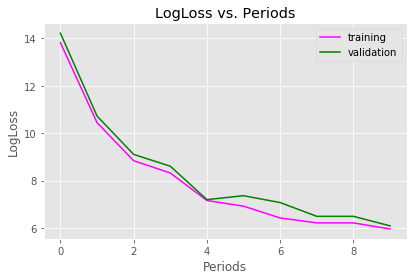

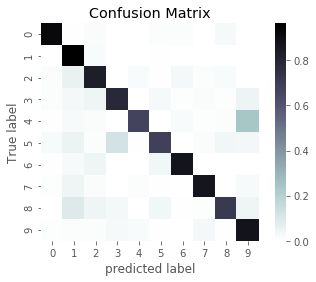

In [12]:
classifier = train_linear_classification_model(
    learning_rate = 0.02,
    steps = 100,
    batch_size = 10,
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)

#### some tracing

In [43]:
predict_training_input_fn = create_predict_input_fn(training_examples,
                                                        training_targets,
                                                        batch_size=10)
predict_validation_input_fn = create_predict_input_fn(validation_examples,
                                                           validation_targets,
                                                           batch_size=10)
print("Training trace: \n")
training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
training_probabilities = np.array([item['probabilities'] for item in training_predictions])
print(training_probabilities,"\n")
training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
print(training_pred_class_id,"\n")
training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id, 10)
print(training_pred_one_hot,"\n")

print("Validation trace: \n")
validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
print(validation_probabilities,"\n")
validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
print(validation_pred_class_id,"\n")
validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id, 10)
print(validation_pred_one_hot)

Training trace: 

[[3.62546765e-03 2.87544094e-02 2.18821764e-02 ... 6.71754107e-02
  5.55840991e-02 3.18184137e-01]
 [1.10724516e-01 2.91693839e-04 2.72068824e-03 ... 6.38668954e-01
  5.31522604e-03 1.55599549e-01]
 [2.20689806e-03 8.34931254e-01 1.66521315e-02 ... 1.52345104e-02
  3.56272645e-02 1.89886242e-02]
 ...
 [6.09993888e-03 4.27811453e-03 2.24927947e-01 ... 9.55489464e-04
  2.87204105e-02 1.69375300e-01]
 [1.94358698e-03 8.99724364e-01 2.14105453e-02 ... 2.80324230e-03
  2.90206280e-02 6.70553837e-03]
 [9.54685558e-04 3.11651547e-03 9.57484424e-01 ... 3.41688516e-04
  3.49428668e-03 5.02595026e-03]] 

[3 7 1 ... 4 1 2] 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]] 

Validation trace: 

[[0.01205921 0.6943053  0.03760824 ... 0.02324308 0.05215157 0.03768695]
 [0.00301721 0.00464811 0.01650829 ... 0.00100283 0.91673994 0.0120687 ]
 [0.00780783 0.23537455 0.11800364 .